<h1><center>ФБ-24 Шевченко Вікторія</center></h1>
<h2><center>Лабораторна робота №7</center></h2>
<h3><center>Сценарії обробки багатоспектральних супутникових зображень</center></h3>

In [2]:
import os
import shutil
import zipfile
import rasterio
import sklearn.metrics
from sentinelhub import SHConfig
from sentinelhub.aws import request
from rasterio.plot import show
from sentinelhub.aws import request
from typing import List
import subprocess
import traceback
import geopandas as gpd
from shapely.geometry import Polygon
from pylandsat.download import Product
import matplotlib.pyplot as plt




<frozen abc>:106: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
/home/kali/Desktop/lab7/env/lib/python3.11/site-packages/rasterio/path.py:15: RasterioDeprecationWarning: rasterio.path will be removed in version 1.4.
  warnings.warn(


### 1. Завантажити необхідні дані Sentinel-2

In [5]:

data_dir = "sentinel_data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Створено папку для даних: '{data_dir}'")
else:
    print(f"Папка для даних '{data_dir}' вже існує.")

# Встановлення конфігурації для Sentinel Hub
config = SHConfig()

product_ids = [
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206",
]


def download_data__sentinel(product_ids, data_dir):
    
    for product_id in product_ids:
        try:
            request.download_safe_format(product_id, folder=data_dir, redownload=False, data_collection='sentinel-s2-l2a')
        except Exception as e:
            traceback.print_exc()

download_data__sentinel(product_ids, data_dir)


Створено папку для даних: 'sentinel_data'


/home/kali/Desktop/lab7/env/lib/python3.11/site-packages/sentinelhub/aws/request.py:245: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  safe_request = AwsProductRequest(product_id, data_folder=folder, bands=bands, safe_format=True)
/home/kali/Desktop/lab7/env/lib/python3.11/site-packages/sentinelhub/aws/data.py:353: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
/home/kali/Desktop/lab7/env/lib/python3.11/site-packages/sentinelhub/aws/data.py:612: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
/home/kali/Desktop/lab7/env/lib/python3.11/site-packages/sentinelhub/aws/data_safe.py:331: SHDeprecationWarning: AWS functionality will rema

### 2. Засобами командного рядка операційної системи (демонстраційні приклади розглянуті для ОС Windows), а також за допомогою бінаріїв бібліотеки GDAL розробити автоматичний сценарій, який здійснюватиме обробку даних ДЗЗ, відповідно до поставлених завдань. Для виконання команд gdal у сценарії Python можна використовувати бібліотеки os та command. Над завантаженими даними Sentinel-2 відпрацювати наступні дії.


### – Розпакування наборів архівів з продуктами ДЗЗ в новостворені папки, назви яких відповідатимуть ідентифікаторам зображень.

In [14]:

directory = "lab"

all_files = os.listdir(directory)

# Відфільтрувати файли, щоб залишити тільки zip-архіви
archive_files = [f for f in all_files if f.endswith('.zip')]
 
output_folder = os.path.join(directory, 'ready_files')
os.makedirs(output_folder, exist_ok=True)

def extract_archive(archive_path, extract_to):
    try:
        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Розпаковано '{archive_path}' до '{extract_to}'")
    except zipfile.BadZipFile:
        print(f"Помилка: '{archive_path}' не є дійсним zip-файлом.")
    except Exception as e:
        print(f"Виникла помилка при розпакуванні '{archive_path}': {e}")

for archive_file in archive_files:
    archive_path = os.path.join(directory, archive_file)
    extract_archive(archive_path, output_folder)

print("Усі архіви успішно розпаковані.")


Розпаковано 'lab/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip' до 'lab/ready_files'
Розпаковано 'lab/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip' до 'lab/ready_files'
Усі архіви успішно розпаковані.


### - Конкатенація каналів видимого, ближнього та середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл.

In [27]:
def concatenate_bands(dir, output_file, letter, x):
    if x == '10m':
        band = 'B08'
    else:
        band = 'B8A'
        
    files = [
        os.path.join(dir, 'GRANULE', f'L2A_T36UU{letter}_A021740_20190821T085815', 'IMG_DATA', f'R{x}', f'T36UU{letter}_20190821T085601_B02_{x}.jp2'),
        os.path.join(dir, 'GRANULE', f'L2A_T36UU{letter}_A021740_20190821T085815', 'IMG_DATA', f'R{x}', f'T36UU{letter}_20190821T085601_B03_{x}.jp2'),
        os.path.join(dir, 'GRANULE', f'L2A_T36UU{letter}_A021740_20190821T085815', 'IMG_DATA', f'R{x}', f'T36UU{letter}_20190821T085601_B04_{x}.jp2'),
        os.path.join(dir, 'GRANULE', f'L2A_T36UU{letter}_A021740_20190821T085815', 'IMG_DATA', f'R{x}', f'T36UU{letter}_20190821T085601_{band}_{x}.jp2')
    ]
    

    missing_files = [file for file in files if not os.path.exists(file)]   

    if missing_files:
        print(f"Не знайдено файли: {missing_files}")
    else:
        gdal_command = [
            'gdal_merge.py',
            '-separate',
            '-o', output_file
        ] + files
        print(f"Running command: {' '.join(gdal_command)}")
        subprocess.run(gdal_command)
        print(f"Конкатенований канал збережено в файл '{output_file}'")
    

product_ids = {
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE": "A",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE": "B",
}

output_folder1 = os.path.join(data_dir, 'ready_files')
os.makedirs(output_folder1, exist_ok=True)

def prompt_overwrite(file_path):
    while True:
        response = input(f"Файл '{file_path}' вже існує. Перезаписати його? (yes/no): ").lower()
        if response in ['yes', 'no']:
            return response == 'yes'


xm = ['10m', '20m', '60m']

for product_id, letter in product_ids.items():
    product_dir = os.path.join(data_dir, product_id)
    for x in xm:
        output_file = os.path.join(output_folder1, f"{letter}_concatenated_{x}.tif")
        
        if os.path.exists(output_file):
            if prompt_overwrite(output_file):
                os.remove(output_file)
                concatenate_bands(product_dir, output_file, letter, x)
        else:
            concatenate_bands(product_dir, output_file, letter, x)


Running command: gdal_merge.py -separate -o sentinel_data/ready_files/A_concatenated_10m.tif sentinel_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R10m/T36UUA_20190821T085601_B02_10m.jp2 sentinel_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R10m/T36UUA_20190821T085601_B03_10m.jp2 sentinel_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R10m/T36UUA_20190821T085601_B04_10m.jp2 sentinel_data/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R10m/T36UUA_20190821T085601_B08_10m.jp2
0...10...20...30...40...50...60...70...80...90...100 - done.
Конкатенований канал збережено в файл 'sentinel_data/ready_files/A_concatenated_10m.tif'
Running command: gdal_merge.py -separate -o sentinel_data/ready_files

CRS of 'sentinel_data/ready_files/A_concatenated_10m.tif': EPSG:32636


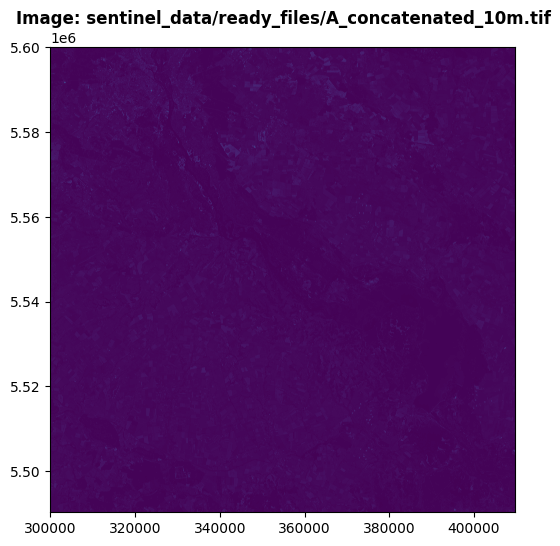

CRS of 'sentinel_data/ready_files/A_concatenated_20m.tif': EPSG:32636


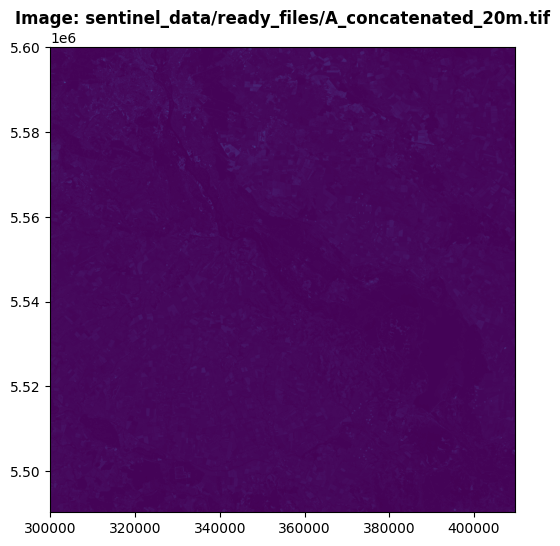

CRS of 'sentinel_data/ready_files/A_concatenated_60m.tif': EPSG:32636


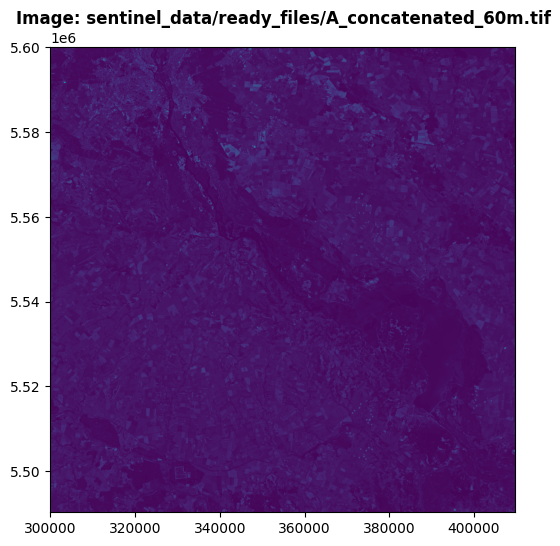

CRS of 'sentinel_data/ready_files/B_concatenated_10m.tif': EPSG:32636


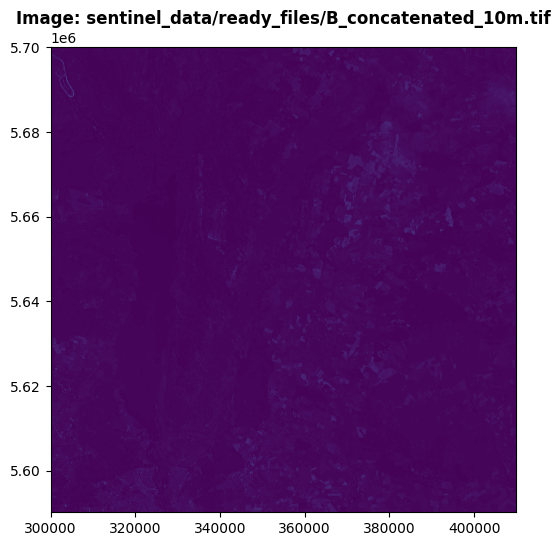

CRS of 'sentinel_data/ready_files/B_concatenated_20m.tif': EPSG:32636


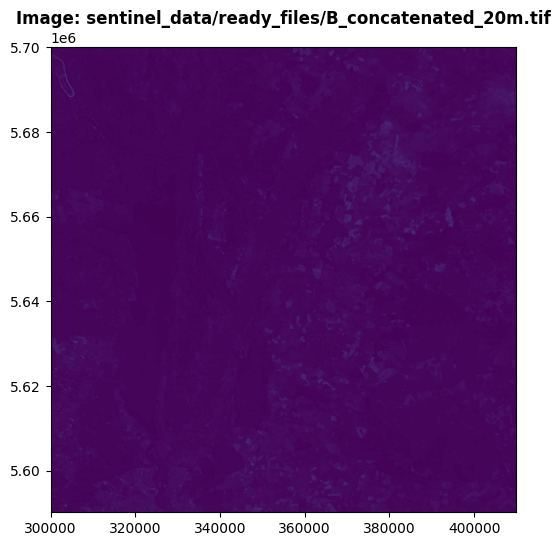

CRS of 'sentinel_data/ready_files/B_concatenated_60m.tif': EPSG:32636


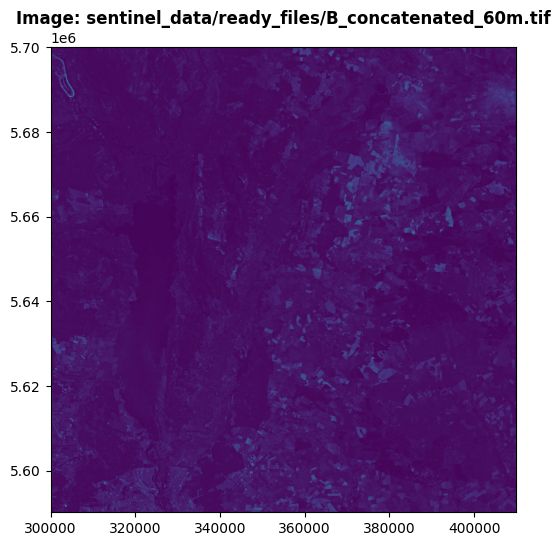

In [8]:
def print_image(file_path):
    try:
        with rasterio.open(file_path) as src:
            print(f"CRS of '{file_path}': {src.crs}")
            
            fig, ax = plt.subplots(figsize=(6, 8))
            rasterio.plot.show(src, ax=ax, title=f"Image: {file_path}")
            plt.show()
    except Exception as e:
        print(f"Помилка при обробці файлу '{file_path}': {e}")
        
product_ids = {
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE": "A",
    "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE": "B",
}
data_dir = "sentinel_data"
xm = ['10m', '20m', '60m']
output_folder1 = os.path.join(data_dir, 'ready_files')
    
for product_id, letter in product_ids.items():
    product_dir = os.path.join(data_dir, product_id)
    for x in xm:
        output_file = os.path.join(output_folder1, f"{letter}_concatenated_{x}.tif")
        print_image(output_file)

### – Перепроектування супутникового зображення у проєкцію 4326.

In [31]:
def reproject_image(input_file, output_file, target_srs='EPSG:4326'):
    if not os.path.exists(input_file):
        print(f"Input file '{input_file}' does not exist.")
        return
    
    if os.path.exists(output_file):
        os.remove(output_file)
        print(f"Output file '{output_file}' вже існував і був видалений.")

    gdal_command = [
        'gdalwarp',
        '-t_srs', target_srs,
        input_file,
        output_file
    ]
    
    subprocess.run(gdal_command)
    print(f"Проекція збережена до '{output_file}'")
    
for product_id, letter in product_ids.items():
    
    for x in xm:
        input_file = os.path.join(output_folder1, f"{letter}_concatenated_{x}.tif")
        output_file = os.path.join(output_folder1, f"{letter}_reprojected4326_{x}.tif")
            
        if os.path.exists(input_file):
            reproject_image(input_file, output_file)
        else:
            print(f"Вхідний файл '{input_file}' не знайдено.") 
               
    # print_image(output_file)


Creating output file that is 13257P x 8536L.
Processing sentinel_data/ready_files/A_concatenated_10m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Проекція збережена до 'sentinel_data/ready_files/A_reprojected4326_10m.tif'
Creating output file that is 6628P x 4268L.
Processing sentinel_data/ready_files/A_concatenated_20m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Проекція збережена до 'sentinel_data/ready_files/A_reprojected4326_20m.tif'
Creating output file that is 2209P x 1423L.
Processing sentinel_data/ready_files/A_concatenated_60m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Проекція збережена до 'sentinel_data/ready_files/A_reprojected4326_60m.tif'
Creating output file that is 13331P x 8421L.
Processing sentinel_data/ready_files/B_concatenated_10m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Проекція збережена до 'sentinel_data/ready_files/B_reprojected4326_10m.tif'
Cr

CRS of 'sentinel_data/ready_files/A_reprojected4326_10m.tif': EPSG:4326


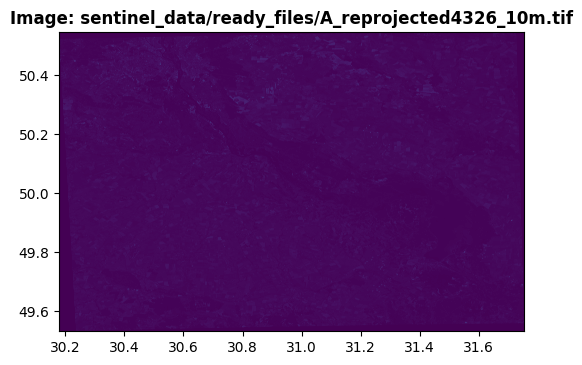

CRS of 'sentinel_data/ready_files/A_reprojected4326_20m.tif': EPSG:4326


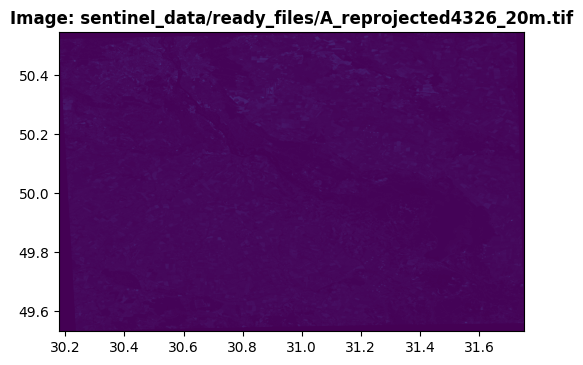

CRS of 'sentinel_data/ready_files/A_reprojected4326_60m.tif': EPSG:4326


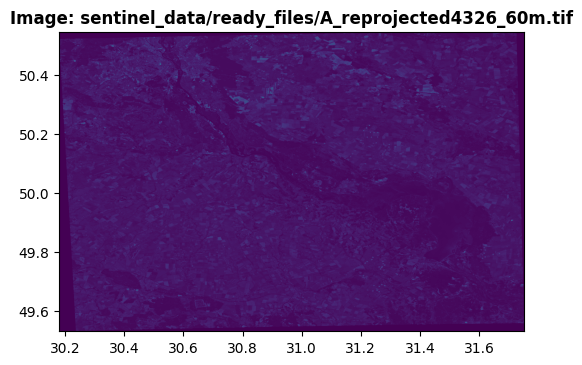

CRS of 'sentinel_data/ready_files/B_reprojected4326_10m.tif': EPSG:4326


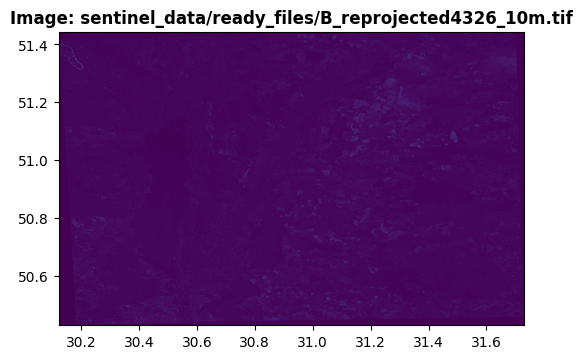

CRS of 'sentinel_data/ready_files/B_reprojected4326_20m.tif': EPSG:4326


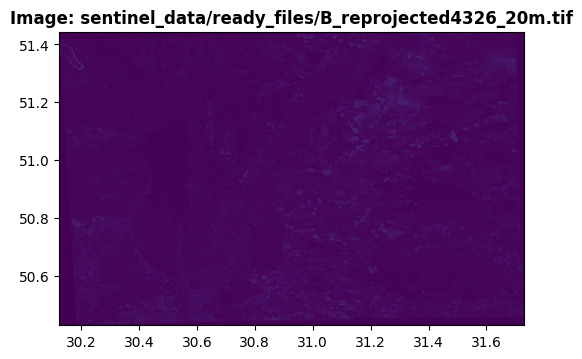

CRS of 'sentinel_data/ready_files/B_reprojected4326_60m.tif': EPSG:4326


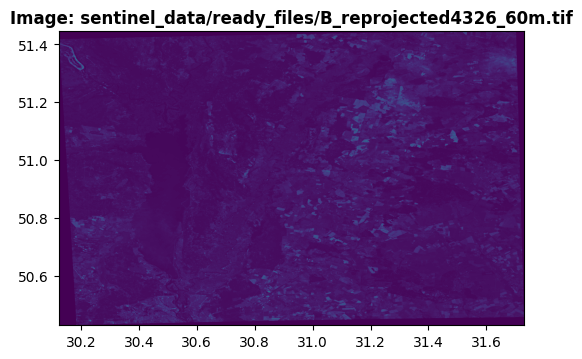

In [9]:
for product_id, letter in product_ids.items():
    
    for x in xm:
        output_file = os.path.join(output_folder1, f"{letter}_reprojected4326_{x}.tif")
        print_image(output_file)

### - Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.

In [36]:
def merge_files(output_file, input_files):
    if os.path.exists(output_file):
        if prompt_overwrite(output_file):
            os.remove(output_file)
            print(f"Старий файл '{output_file}' видалено.")
        else:
            print(f"Не перезаписано файл '{output_file}'.")
            return

    gdal_merge_cmd = [
        'gdal_merge.py',
        '-separate',
        '-o', output_file
    ] + input_files
    
    os.system(gdal_merge_cmd)
    print(f"Файл '{output_file}' створено.")

def prompt_overwrite(file_path):
    while True:
        response = input(f"Файл '{file_path}' вже існує. Перезаписати його? (yes/no): ").lower()
        if response in ['yes', 'no']:
            return response == 'yes'

concatenated_files = [
    ('concatenated_10m.tif', ['A_concatenated_10m.tif', 'B_concatenated_10m.tif']),
    ('concatenated_20m.tif', ['A_concatenated_20m.tif', 'B_concatenated_20m.tif']),
    ('concatenated_60m.tif', ['A_concatenated_60m.tif', 'B_concatenated_60m.tif'])
]

reprojected_files = [
    ('reprojected4326_10m.tif', ['A_reprojected4326_10m.tif', 'B_reprojected4326_10m.tif']),
    ('reprojected4326_20m.tif', ['A_reprojected4326_20m.tif', 'B_reprojected4326_20m.tif']),
    ('reprojected4326_60m.tif', ['A_reprojected4326_60m.tif', 'B_reprojected4326_60m.tif'])
]

final_dir = 'sentinel_data/final_images'
os.makedirs(final_dir, exist_ok=True)

for output_file, input_files in concatenated_files:
    output_path = os.path.join(final_dir, output_file)
    input_paths = [os.path.join(output_folder1, file) for file in input_files]
    merge_files(output_path, input_paths)

for output_file, input_files in reprojected_files:
    output_path = os.path.join(final_dir, output_file)
    input_paths = [os.path.join(output_folder1, file) for file in input_files]
    merge_files(output_path, input_paths)

0...10...20...30...40...50...60...70...80...90...100 - done.
Файл 'sentinel_data/final_images/concatenated_10m.tif' створено.
0...10...20...30...40...50...60...70...80...90...100 - done.
Файл 'sentinel_data/final_images/concatenated_20m.tif' створено.
0...10...20...30...40...50...60...70...80...90...100 - done.
Файл 'sentinel_data/final_images/concatenated_60m.tif' створено.
0...10...20...30...40...50...60...70...80...90...100 - done.
Файл 'sentinel_data/final_images/reprojected4326_10m.tif' створено.
0...10...20...30...40...50...60...70...80...90...100 - done.
Файл 'sentinel_data/final_images/reprojected4326_20m.tif' створено.
0...10...20...30...40...50...60...70...80...90...100 - done.
Файл 'sentinel_data/final_images/reprojected4326_60m.tif' створено.


### - Обрізання результуючого зображення по заданому векторному контуру.


In [37]:

# Координати полігону для Києва
coordinates = [(29.073321247506765, 49.845775018245774),
               (31.986007792928522, 49.845775018245774),
               (31.986007792928522, 51.278667808079206),
               (29.073321247506765, 51.278667808079206),
               (29.073321247506765, 49.845775018245774)]

# Створення полігону за координатами
polygon = Polygon(coordinates)
gdf = gpd.GeoDataFrame(geometry=[polygon])

output_shapefile = "sentinel_data/final_images/Kyiv_regions.shp"
gdf.to_file(output_shapefile)


In [7]:
def clip_image(input_image, output_image, shapefile):
    gdal_command = [
        'gdalwarp',
        '-cutline', shapefile,
        '-crop_to_cutline',
        input_image,
        output_image
    ]
    subprocess.run(gdal_command)
    print(f"Зображення обрізано. Результат збережено '{output_image}'.")
final_dir = 'sentinel_data/final_images'
shapefile = os.path.join(final_dir, 'Kyiv_regions.shp')

concatenated_files = [
    'concatenated_10m.tif', 'concatenated_20m.tif', 'concatenated_60m.tif'
]

reprojected_files = [
    'reprojected4326_10m.tif', 'reprojected4326_20m.tif', 'reprojected4326_60m.tif'
]


for file in concatenated_files:
    input_image = os.path.join(final_dir, file)
    output_image = os.path.join(final_dir, f'cut_{file}')
    clip_image(input_image, output_image, shapefile)

for file in reprojected_files:
    input_image = os.path.join(final_dir, file)
    output_image = os.path.join(final_dir, f'cut_{file}')
    clip_image(input_image, output_image, shapefile)

Creating output file that is 4067P x 4251L.
Processing sentinel_data/final_images/concatenated_10m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Зображення обрізано. Результат збережено 'sentinel_data/final_images/cut_concatenated_10m.tif'.
Creating output file that is 2033P x 2125L.
Processing sentinel_data/final_images/concatenated_20m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Зображення обрізано. Результат збережено 'sentinel_data/final_images/cut_concatenated_20m.tif'.
Creating output file that is 677P x 707L.
Processing sentinel_data/final_images/concatenated_60m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Зображення обрізано. Результат збережено 'sentinel_data/final_images/cut_concatenated_60m.tif'.
Creating output file that is 4834P x 3172L.
Processing sentinel_data/final_images/reprojected4326_10m.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Зображення обрізано. Ре

### 3. Протестувати різні реалізовані в gdal методи паншарпенінгу.

### Завантаження Landsat-8

In [10]:

scene_ids = [
    "LC08_L1TP_182025_20190830_20190903_01_T1",
    "LC08_L1TP_182026_20190830_20190903_01_T1"
]

output_dir = 'landsat_downloads'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for scene_id in scene_ids:
    product = Product(scene_id)
    scene_dir = os.path.join(output_dir, scene_id)

    try:
        print(f"Завантаження знімка {scene_id}...")
        product.download(scene_dir, progressbar=True, verify=False)
        print(f"Знімок {scene_id} завантажено успішно.")
    except Exception as e:
        print(f"Помилка завантаження знімка {scene_id}: {e}")
        continue


    if os.path.isdir(scene_dir):
        contents = os.listdir(scene_dir)
        if f"{scene_id}_B1.TIF" in contents and f"{scene_id}_MTL.txt" in contents:
            print(f"Знімок {scene_id} завантажено успішно.")
    else:
        print(f"Помилка завантаження знімка {scene_id}: каталог не створено.")

Завантаження знімка LC08_L1TP_182025_20190830_20190903_01_T1...


LC08_L1TP_182025_20190830_20190903_01_T1_B1.TIF: : 65.0MB [00:06, 10.2MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B2.TIF: : 67.1MB [00:06, 10.3MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B3.TIF: : 71.3MB [00:06, 10.4MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B4.TIF: : 76.5MB [00:09, 7.92MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B5.TIF: : 90.2MB [00:08, 10.7MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B6.TIF: : 89.1MB [00:08, 10.2MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B7.TIF: : 86.0MB [00:07, 10.8MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B8.TIF: : 285MB [00:27, 10.5MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B9.TIF: : 45.1MB [00:05, 8.33MB/s]                          
LC08_L1TP_182025_20190830_20190903_01_T1_B10.TIF: : 66.1MB [00:06, 9.71MB/s]       

Знімок LC08_L1TP_182025_20190830_20190903_01_T1 завантажено успішно.
Завантаження знімка LC08_L1TP_182026_20190830_20190903_01_T1...


LC08_L1TP_182026_20190830_20190903_01_T1_B1.TIF: : 66.1MB [00:06, 10.4MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B2.TIF: : 69.2MB [00:06, 10.6MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B3.TIF: : 73.4MB [00:06, 10.7MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B4.TIF: : 78.6MB [00:07, 10.6MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B5.TIF: : 90.2MB [00:08, 11.2MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B6.TIF: : 87.0MB [00:08, 10.8MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B7.TIF: : 84.9MB [00:10, 8.41MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B8.TIF: : 289MB [00:25, 11.3MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B9.TIF: : 45.1MB [00:04, 9.95MB/s]                          
LC08_L1TP_182026_20190830_20190903_01_T1_B10.TIF: : 67.1MB [00:06, 10.6MB/s]       

Знімок LC08_L1TP_182026_20190830_20190903_01_T1 завантажено успішно.


### Підготуйте склеєні RGB канали Landsat-8 та окремо панхроматичний. Переведіть панхроматичний канал у 30 м, а RGB канали у 60 метрів.


In [43]:
lansat_dir = 'landsat_downloads'

processed_dir = 'processed_landsat'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)
    
scene_ids = [
    "LC08_L1TP_182025_20190830_20190903_01_T1",
    "LC08_L1TP_182026_20190830_20190903_01_T1"
]

for scene_id in scene_ids:
    scene_path = os.path.join(lansat_dir, scene_id, scene_id)
    
    channel_paths = [os.path.join(scene_path, '{}_B{}.TIF'.format(scene_id, i)) for i in range(2, 5)]

    output_merged_path = os.path.join(processed_dir, f'{scene_id}_concatenated.tif')
    merge_command = ['gdal_merge.py', '-o', output_merged_path] + channel_paths
    subprocess.call(merge_command)
    
    output_resampled_path = os.path.join(processed_dir, f'{scene_id}_60.tif')
    resample_command = ['gdal_translate', '-tr', '60', '60', output_merged_path, output_resampled_path]
    subprocess.call(resample_command)

    pan_path = os.path.join(scene_path, '{}_B8.TIF'.format(scene_id)) 
    output_pan_resampled_path = os.path.join(processed_dir, f'{scene_id}_30.tif')
    resample_pan_command = ['gdal_translate', '-tr', '30', '30', pan_path, output_pan_resampled_path]
    subprocess.call(resample_pan_command)

print("Зображення оброблено успішно для всіх сцен.")

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 7761, 7861
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 15521, 15721
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 7771, 7871
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 15541, 15741
0...10...20...30...40...50...60...70...80...90...100 - done.
Зображення оброблено успішно для всіх сцен.


### Після цього паншарпніть 60 метровий RGB за допомогою 30 м панхроматичного каналу. Після цього ви отримуєте два 30 метрових RGB зображення - перший оригінальний, другий паншарпнутий.

In [44]:
output_pansharpen_dir = 'pansharpen'
if not os.path.exists(output_pansharpen_dir):
    os.makedirs(output_pansharpen_dir)
    
pansharpen_methods = ['nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos', 'average']

for scene_id in scene_ids:    
    for method in pansharpen_methods:
            output_file = f'{scene_id}_pansharpen_{method}.tif'
            pansharpen_cmd = f'gdal_pansharpen.py -r {method} {output_pan_resampled_path} {output_resampled_path} {os.path.join(output_pansharpen_dir, output_file)}'
            subprocess.call(pansharpen_cmd, shell=True)

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


### Підрахуйте метрики точності паншарпенінгу (це будь які вам відомі метрики які можна використовувати для валідації регресії, наприклад r square). За даними метриками виберіть найкращий метод паншарпенінгу.

In [9]:
import os
import rasterio
from rasterio.windows import Window
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
import numpy as np
import pandas as pd


pansharpen_dir = 'pansharpen'

processed_dir = 'processed_landsat'
scene_ids = [
    "LC08_L1TP_182025_20190830_20190903_01_T1",
    "LC08_L1TP_182026_20190830_20190903_01_T1"
]
# Список методів паншарпенінгу
pansharpen_methods = ['nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos', 'average']


min_height = float('inf')
min_width = float('inf')

for scene_id in scene_ids:
    orig_path = os.path.join(processed_dir, f'{scene_id}_30.tif')
    with rasterio.open(orig_path) as src:
        orig_height, orig_width = src.height, src.width
        min_height = min(min_height, orig_height)
        min_width = min(min_width, orig_width)

    for method in pansharpen_methods:
        pansharpen_path = os.path.join(pansharpen_dir, f'{scene_id}_pansharpen_{method}.tif')
        with rasterio.open(pansharpen_path) as pan:
            pan_height, pan_width = pan.height, pan.width
            min_height = min(min_height, pan_height)
            min_width = min(min_width, pan_width)

results = []

for scene_id in scene_ids:
    orig_path = os.path.join(processed_dir, f'{scene_id}_30.tif')
    with rasterio.open(orig_path) as src:
        orig_data = src.read(window=Window(0, 0, min_height, min_width))
        for method in pansharpen_methods:
            pansharpen_path = os.path.join(pansharpen_dir, f'{scene_id}_pansharpen_{method}.tif')
            with rasterio.open(pansharpen_path) as pan:
                pansharpen_data = pan.read(window=Window(0, 0, min_height, min_width))
                
                # Перевірка форми масивів
                if orig_data.shape != pansharpen_data.shape:
                    print(f"Форми масивів не співпадають для Scene ID: {scene_id}, Method: {method}")
                    continue
                
                # Обрізання даних до спільного діапазону значень
                orig_data_min = orig_data.min()
                orig_data_max = orig_data.max()
                pansharpen_data_min = pansharpen_data.min()
                pansharpen_data_max = pansharpen_data.max()
                
                data_min = max(orig_data_min, pansharpen_data_min)
                data_max = min(orig_data_max, pansharpen_data_max)
                
                orig_data = np.clip(orig_data, data_min, data_max)
                pansharpen_data = np.clip(pansharpen_data, data_min, data_max)
                
                # Розрахунок метрик
                r2 = r2_score(orig_data.ravel(), pansharpen_data.ravel())
                mse = mean_squared_error(orig_data.ravel(), pansharpen_data.ravel())
                mae = mean_absolute_error(orig_data.ravel(), pansharpen_data.ravel())
                max_err = max_error(orig_data.ravel(), pansharpen_data.ravel())
                
                results.append({
                    'Scene ID': scene_id,
                    'Method': method,
                    'R-squared': r2,
                    'MSE': mse,
                    'MAE': mae,
                    'Max Error': max_err
                })

df = pd.DataFrame(results)
display(df)


Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: nearest
Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: bilinear
Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: cubic
Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: cubicspline
Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: lanczos
Форми масивів не співпадають для Scene ID: LC08_L1TP_182025_20190830_20190903_01_T1, Method: average


,Scene ID,Method,R-squared,MSE,MAE,Max Error
0,LC08_L1TP_182026_20190830_20190903_01_T1,nearest,0.996870,25.389941,45.091486,42457
1,LC08_L1TP_182026_20190830_20190903_01_T1,bilinear,0.998144,15.137398,26.846837,17332
2,LC08_L1TP_182026_20190830_20190903_01_T1,cubic,0.998298,13.902919,24.652527,17072
3,LC08_L1TP_182026_20190830_20190903_01_T1,cubicspline,0.999839,1.321928,2.324261,17332
4,LC08_L1TP_182026_20190830_20190903_01_T1,lanczos,0.998373,13.311120,23.590161,17072
5,LC08_L1TP_182026_20190830_20190903_01_T1,average,0.997634,19.347865,34.392920,21556


In [8]:
best_methods = df.loc[df.groupby('Scene ID')['R-squared'].idxmax()]
print("\nНайкращий метод за R-squared для кожної сцени:")
display(best_methods)


Найкращий метод за R-squared для кожної сцени:


,Scene ID,Method,R-squared,MSE,MAE,Max Error
3,LC08_L1TP_182026_20190830_20190903_01_T1,cubicspline,0.999839,1.321928,2.324261,17332
